In [1]:
using_numpy = False
try:
    import cupy as np
except:
    import numpy as np
    using_numpy = True

from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

In [2]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz")

In [3]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)


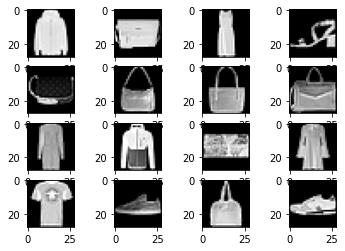

In [4]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        img = trainxs[np.random.randint(0, len(trainxs))]
        if not using_numpy:
            img = img.get()
        axarr[i, j].imshow(img)

## 3.3 Implementing the algorithm

In [5]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))
#     return np.exp(np.fmin(z, 0)) / (1 + np.exp(-np.abs(z)))

def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

def loss(yhat, y):
    if yhat in (0, 1):
        return np.array([[0]])
    return (-y * np.log(yhat)) - ((1 - y) * np.log(1 - yhat))

In [6]:
def forward(params, x):
    """Compute Forward Pass"""
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["w2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    
    return forward_res

def backprop(x, y, params):
    """Compute Gradients"""
    x = x.reshape(28**2, 1)
    
    fwd_pass = forward(params, x)
    
    # Backwards Pass
    dL_dz2 = (fwd_pass["a2"] - y)
    dL_dz1 = dL_dz2 * params["w2"].T * sigmoid_d(fwd_pass["z1"])
    
    grad = {}
    grad["w2"] = dL_dz2 * fwd_pass["a1"].T
    grad["b2"] = dL_dz2
    
    grad["W1"] = dL_dz1 @ x.T
    grad["b1"] = dL_dz1

    return grad

In [7]:
def predict_raw(x, params):
    """Get raw model activation for given training sample"""
    forward_res = forward(params, x)
    return forward_res["a2"]

def predict_class(yhat):
    """Get class prediction for given activation"""
    if yhat >= 0.5:
        return 1
    return 0

In [8]:
def nvalidate(xs, ys, params):
    """Returns (Dataset Loss, Dataset Accuracy)"""
    l, accuracy = 0, 0
    nData = xs.shape[0]
    for i in range(nData):
        yhat = predict_raw(xs[i], params) # Raw activation
        y_pred = predict_class(yhat) # Class prediction (binary)
        # Add Log Likelihood Loss
        if yhat not in (0, 1):
            l += (-ys[i] * np.log(yhat)) - ((1 - ys[i]) * np.log(1 - yhat))
        if y_pred == ys[i]:
            accuracy += 1
    return l.item() / nData, accuracy / nData       

In [15]:
def mlp(xs, ys, devxs, devys, n_epochs=3, learning_rate=0.1, momentum=0, batch_size=0, h=19):
    """Initialize and train model on a dataset, outputting validation set accuracy/loss"""
    # Initialize Hyperparameters
    img_size = 28**2
    out_size = 1
    nData = xs.shape[0]
    
    lr = learning_rate
    a = momentum # alpha
    
    # Enable Full Batch (set batch size 1 for s.g.d.)
    if batch_size == 0:
        batch_size = nData
        
    print("nData:", nData, "Hidden Layer size:", h, "Learning Rate:", lr, "Momentum:", momentum, "Batch Size:", batch_size)
    
    # Initialize training metadata containers
    epochs = []
    t_losses, v_losses = [], []
    t_accs, v_accs = [], []
    
    # Initialize model parameters
    params = {"W1": np.random.randn(h, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h, 1)),
              "w2": np.random.randn(out_size, h) * np.sqrt(1 / h),
              "b2": np.zeros((out_size, 1))}
    
    # Initialize Grad vector
    grad = {}
    # Initialize Update Vector nu
    v = {
        "W1": np.zeros_like(params["W1"]),
        "b1": np.zeros_like(params["b1"]),
        "w2": np.zeros_like(params["w2"]),
        "b2": np.zeros_like(params["b2"]),
    }
    
    for epoch in range(n_epochs):
        epochs.append(epoch)
        print("----------------------------------\nEpoch:", epoch)
        
        v_loss, v_acc = nvalidate(devxs, devys, params)
        v_accs.append(v_acc)
        v_losses.append(v_loss)
        print("Val Acc:", v_acc, "Val Loss:", v_loss)

        # Randomly shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]
        
        # Get array of arrays containing batch_size array indices
        batch_indices = np.split(np.arange(nData), (nData // batch_size))
        
        for batch in batch_indices:
            # Initialize gradients to zero
            grad["w2"] = np.zeros_like(params["w2"])
            grad["b2"] = np.zeros_like(params["b2"])
            grad["W1"] = np.zeros_like(params["W1"])
            grad["b1"] = np.zeros_like(params["b1"])
            
            for i in batch:
                grad_i = backprop(trainxs_shuffled[i], trainys_shuffled[i], params)
                
                grad["w2"] += grad_i["w2"] / batch_size
                grad["b2"] += grad_i["b2"] / batch_size
                grad["W1"] += grad_i["W1"] / batch_size
                grad["b1"] += grad_i["b1"] / batch_size
                
            v["W1"] = a * v["W1"] + (1-a) * grad["W1"]
            v["b1"] = a * v["b1"] + (1-a) * grad["b1"]
            v["w2"] = a * v["w2"] + (1-a) * grad["w2"]
            v["b2"] = a * v["b2"] + (1-a) * grad["b2"]
            
            params["W1"] -= lr * v["W1"]
            params["b1"] -= lr * v["b1"]
            params["w2"] -= lr * v["w2"]
            params["b2"] -= lr * v["b2"]
        
        t_loss, t_acc = nvalidate(xs, ys, params)
        t_accs.append(t_acc)
        t_losses.append(t_loss)
        
        
    return epochs, t_losses, t_accs, v_losses, v_accs, params

In [10]:
# nn_gridsearch = {}

In [14]:
nn_gridsearch.keys()

dict_keys(['hids19_momt0_lr0.1_bchsz1_epch50', 'hids19_momt0_lr0.1_bchsz8_epch50', 'hids19_momt0_lr0.1_bchsz1000_epch50', 'hids19_momt0_lr0.1_bchsz12000_epch50'])

In [16]:
mts = [0, 0.2, 0.4] # momentum
lrs = [0.1, 0.01, 0.001] # learning rate
bzs = [1, 8, 1000, 12000] # batch size
hzs = [19, 41] # hidden layer size
n_epochs = 50 # number of epochs
for hz in hzs:
    for mt in mts:
        for lr in lrs:
            for bz in bzs:
                key = "hids{}_momt{}_lr{}_bchsz{}_epch{}".format(hz, mt, lr, bz, n_epochs)
                print("Running", key)
                if lr < 0.1 and bz > 2000:
                    print("Skipping", key)
                    continue
                if key in nn_gridsearch.keys():
                    print("Skipping", key)
                    continue
                nn_gridsearch[key] = mlp(
                    trainxs, trainys,
                    devxs, devys,
                    n_epochs=n_epochs,
                    learning_rate=lr,
                    momentum=mt,
                    batch_size=bz,
                    h=hz,
                )

Running hids19_momt0_lr0.1_bchsz1_epch50
Skipping hids19_momt0_lr0.1_bchsz1_epch50
Running hids19_momt0_lr0.1_bchsz8_epch50
Skipping hids19_momt0_lr0.1_bchsz8_epch50
Running hids19_momt0_lr0.1_bchsz1000_epch50
Skipping hids19_momt0_lr0.1_bchsz1000_epch50
Running hids19_momt0_lr0.1_bchsz12000_epch50
Skipping hids19_momt0_lr0.1_bchsz12000_epch50
Running hids19_momt0_lr0.01_bchsz1_epch50
nData: 12000 Hidden Layer size: 19 Learning Rate: 0.01 Momentum: 0 Batch Size: 1
----------------------------------
Epoch: 0
Val Acc: 0.441 Val Loss: 0.7013301821651694
----------------------------------
Epoch: 1
Val Acc: 0.973 Val Loss: 0.09869698870978139
----------------------------------
Epoch: 2
Val Acc: 0.974 Val Loss: 0.07886984428766182
----------------------------------
Epoch: 3
Val Acc: 0.98 Val Loss: 0.07145564516783569
----------------------------------
Epoch: 4
Val Acc: 0.98 Val Loss: 0.07120421317483368
----------------------------------
Epoch: 5
Val Acc: 0.983 Val Loss: 0.061655993013604284

In [19]:
nn_gridsearch.keys()

dict_keys(['hids19_momt0_lr0.1_bchsz1_epch50', 'hids19_momt0_lr0.1_bchsz8_epch50', 'hids19_momt0_lr0.1_bchsz1000_epch50', 'hids19_momt0_lr0.1_bchsz12000_epch50', 'hids19_momt0_lr0.01_bchsz1_epch50', 'hids19_momt0_lr0.01_bchsz8_epch50', 'hids19_momt0_lr0.01_bchsz1000_epch50', 'hids19_momt0_lr0.001_bchsz1_epch50', 'hids19_momt0_lr0.001_bchsz8_epch50', 'hids19_momt0_lr0.001_bchsz1000_epch50', 'hids19_momt0.2_lr0.1_bchsz1_epch50', 'hids19_momt0.2_lr0.1_bchsz8_epch50', 'hids19_momt0.2_lr0.1_bchsz1000_epch50', 'hids19_momt0.2_lr0.1_bchsz12000_epch50', 'hids19_momt0.2_lr0.01_bchsz1_epch50', 'hids19_momt0.2_lr0.01_bchsz8_epch50', 'hids19_momt0.2_lr0.01_bchsz1000_epch50', 'hids19_momt0.2_lr0.001_bchsz1_epch50', 'hids19_momt0.2_lr0.001_bchsz8_epch50', 'hids19_momt0.2_lr0.001_bchsz1000_epch50', 'hids19_momt0.4_lr0.1_bchsz1_epch50', 'hids19_momt0.4_lr0.1_bchsz8_epch50', 'hids19_momt0.4_lr0.1_bchsz1000_epch50', 'hids19_momt0.4_lr0.1_bchsz12000_epch50', 'hids19_momt0.4_lr0.01_bchsz1_epch50', 'hids19

In [20]:
import pickle

In [21]:
with open("gridsearch_monolith_2lp.p", "wb") as fp:
    pickle.dump(nn_gridsearch, fp, protocol=pickle.HIGHEST_PROTOCOL)